In this chapter, we’re going to be looking at the same dataset as last chapter, but this time, we’ll run it through a neural network

In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
df = pd.read_csv(r'https://raw.githubusercontent.com/a-coders-guide-to-ai/a-coders-guide-to-neural-networks/master/data/diabetes.csv')

Just a note — although there are many types of neural networks, the kind of neural network we’ll be looking at is a feed forward network. It’s also often commonly referred to as a fully connected neural network.
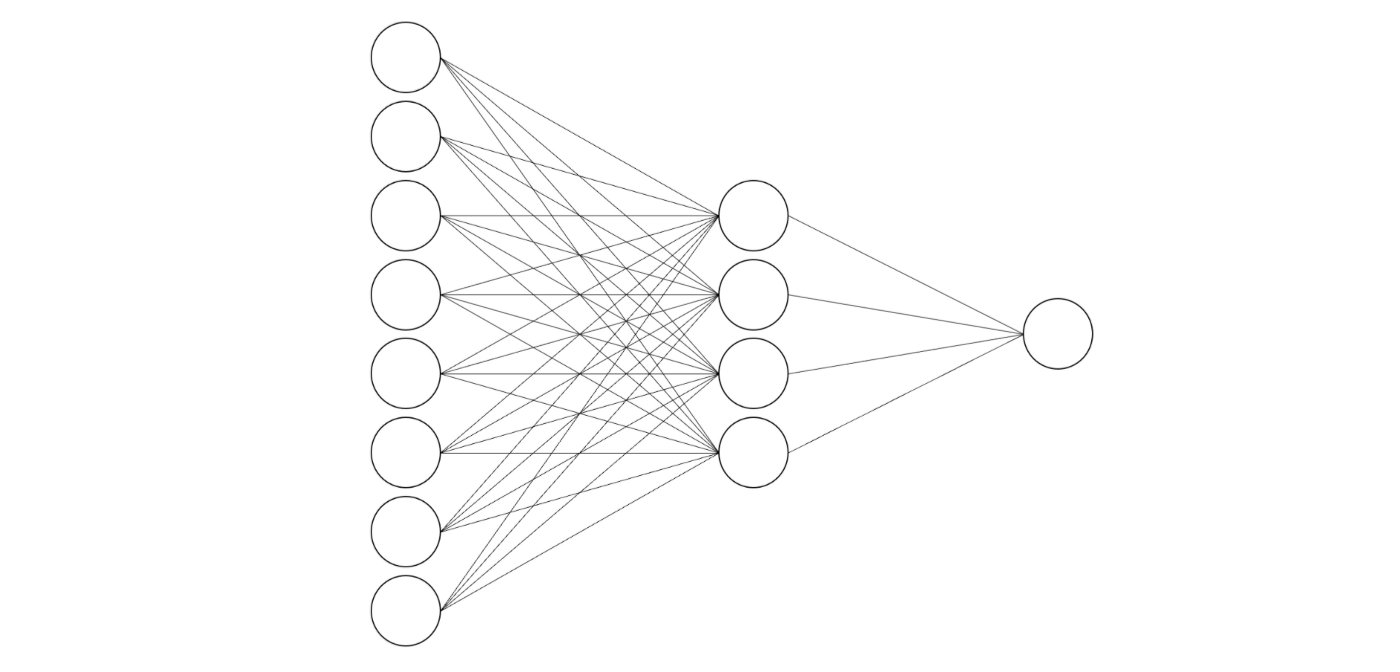

This time, we have 4 separate logistic regression equations (the same equation) being performed on the 8 features, in parallel. We will start with randomly assigned weights will give us 4 different outcomes. Those 4 outcomes are then used as the new features which feed into the last neuron, providing us with our prediction.

In [5]:
hidden_nodes = 4 # number of features in the hidden layer
amount_of_features = 8 # Number of features in the data set
torch.random.manual_seed(1234) # random seed for the random numbers
hidden_weights = torch.rand((hidden_nodes, amount_of_features+1), dtype=float, requires_grad=True) # Y = X*weights[0:7] + weights[8]*1, assigning random weights to 4 hidden nodes 
# weights are typically the slope and bias if you think about linear and logistic regression
torch.random.manual_seed(1234)
output_weights = torch.rand((1, hidden_nodes+1), dtype=float, requires_grad=True) # Weights assigned to the final layer or output layer. Now instead of 9 (8+1) features, we have 5 (4+1)

Let’s start implementing the code for our neural network. We’ll begin with converting our data to tensors.

In [ ]:
X = df[df.columns[:-1]]
y = df['Outcome']
X = torch.tensor(X.values)
y = torch.tensor(y.values)
X = torch.cat((X, torch.ones(X.shape[0], dtype=float).reshape(-1,1)), dim=1)
def BCE(y, y_pred): ##log loss error (binary cross entropy)
  return -torch.sum((y*torch.log(y_pred) + (1-y)*torch.log(1-y_pred)))/y.shape[0]

def sigmoid(linear):
    return 1/(1+torch.exp(-linear))

def accuracy(y_pred, y): # function for calculating accuracy
    return torch.sum((((y_pred>=0.5)+0).reshape(1,-1)==y)+0).item()/y.shape[0]
epoch_loss = []

learning_rate = 1e-3
n = X.shape[0]

for epoch in range(5000+1): 
    ##hidden layer##
    hidden_linear = hidden_weights@X.T
    hidden_output = sigmoid(hidden_linear)
    hidden_output = torch.cat((hidden_output, torch.ones(hidden_output.shape[1], dtype=float).reshape(1,-1)), dim=0)
    ################
    output_linear = output_weights@hidden_output
    y_pred = sigmoid(output_linear)
    loss = BCE(y, y_pred)
    epoch_loss.append(loss.item())

    ###backpropagation###
    loss.backward()

    ###step###
    with torch.no_grad():
        hidden_weights -= learning_rate * hidden_weights.grad
        output_weights -= learning_rate * output_weights.grad

    hidden_weights.grad.zero_()
    output_weights.grad.zero_()

    if(epoch % 1000 == 0):
        print('epoch: {0} - loss: {1:.5f}; acc: {2:.3f}'.format(epoch, epoch_loss[-1], accuracy(y_pred, y)))

The accuracy of the neural network model is 65% compared to 70% for logistic regression from the last chapter? The truth is, neural networks do in fact often outperform traditional machine learning techniques, but there are a few tricks needed to really get those results. Before we dive into those tricks, let’s go over splitting our dataset.

Let's get into the details of training/testing dataset to further evaluate our options.

The real way to tell if our model is good at predicting is to show it data that it’s never seen before. How do we do that? Simple. We just take our dataset and randomly set aside a percentage of the rows for testing. Those testing rows are rows in the dataset which our model has never seen before, but because our model should have gotten a good idea of our domain of interest from the training data, it should be able to deduce the answers (i.e., predict) for the testing data.

The steps needed to perform this is to randomly shuffle the dataset and then set aside a portion of the data. It allows our testing set to have the same representation as our training set. We could write this from scratch, but it’s better (and easier) to use scikit-learn’s built-in train_test_split function.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 
# The test_size is set to 0.33. That’s us telling the function to allocate 1/3 (~33%) of the data for the test set and the rest of the data for the train set.


The next step is standardization to scale the data to center around 0 (mean of 0) and have the standard deviation to be 1.

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = torch.tensor(scaler.transform(X_train))
X_test = torch.tensor(scaler.transform(X_test))

In [ ]:
torch.random.manual_seed(1234)
hidden_weights = torch.rand((hidden_nodes, amount_of_features+1), dtype=float, requires_grad=True)
torch.random.manual_seed(1234)
output_weights = torch.rand((1, hidden_nodes+1), dtype=float, requires_grad=True)

train_loss = []
test_loss = []

learning_rate = 1e-2
n = X_train.shape[0]

for epoch in range(50000+1): 
    ##hidden layer##
    hidden_linear = hidden_weights@X_train.T
    hidden_output = sigmoid(hidden_linear)
    hidden_output = torch.cat((hidden_output, torch.ones(hidden_output.shape[1], dtype=float).reshape(1,-1)), dim=0)
    ################
    output_linear = output_weights@hidden_output
    y_pred = sigmoid(output_linear)
    loss = BCE(y_train, y_pred)
    train_loss.append(loss.item())

    ###backpropagation###
    loss.backward()

    ###step###
    with torch.no_grad():
        hidden_weights -= learning_rate * hidden_weights.grad
        output_weights -= learning_rate * output_weights.grad

    hidden_weights.grad.zero_()
    output_weights.grad.zero_()
    
    if(epoch % 10000 == 0):
        print('Train: epoch: {0} - loss: {1:.5f}; acc: {2:.3f}'.format(epoch, train_loss[-1], accuracy(y_pred, y_train)))
    
    ####run model on test set####
    hidden_linear = hidden_weights@X_test.T
    hidden_output = sigmoid(hidden_linear)
    hidden_output = torch.cat((hidden_output, torch.ones(hidden_output.shape[1], dtype=float).reshape(1,-1)), dim=0)
    output_linear = output_weights@hidden_output
    y_pred = sigmoid(output_linear)
    loss = BCE(y_test, y_pred)
    test_loss.append(loss.item())

    if(epoch % 10000 == 0):
        print('Test: epoch: {0} - loss: {1:.5f}; acc: {2:.3f}'.format(epoch, test_loss[-1], accuracy(y_pred, y_test)))

Even though we’re training with less data, we’re getting significantly better results after standardization. 78% accuracy on our training set and 76% accuracy on our test set. That’s much better than we received before standardizing and noticeably better than our logistic regression algorithm.

Using Pytorch framwork to write neural network codes.

In [ ]:
import torch.nn as nn

Now creating the class components of neural network architecture 

In [ ]:
class Model(nn.Module):
    
    def __init__(self, hidden_nodes, amount_of_features):
        super().__init__()
        self.hidden_linear = nn.Linear(amount_of_features, hidden_nodes)
        self.output_linear = nn.Linear(hidden_nodes, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X):
        hidden_output = self.sigmoid(self.hidden_linear(X)) # hidden layer goes into our sigmoid function, creating our hidden_output variable
        output = self.sigmoid(self.output_linear(hidden_output)) # hidden_output variable goes into the last linear layer and through the final activation function, providing us with our outpu
        return output

Easy to declare our loss function and gradient descent algorithm using PyTorch’s native functionality.

In [ ]:
model = Model(hidden_nodes, amount_of_features)
BCE = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)